# ABC del diagrama HR (Color-Magnitud) de un catálogo estelar en Python

En este ejemplo intentamos representar un Diagrama Herzprung-Russell a partir de una muestra
del catálogo estelar HIPPARCOS-2, haciendo uso de la biblioteca Matplotlib. Se ensaya, además,
un método simple de clasificación de las estrellas con una técnica de aprendizaje automático.
En realidad, cuando no se representan exactamente los valores de Temperatura vs. Luminosidad,
se dice que es un diagrama Color-Magnitud.

Se declaran bibliotecas comunes para descargar y leer un archivo comprimido.

In [ ]:
import requests
from google.colab import files
#import gzip
#from io import BytesIO

Se carga el catálogo estelar HIPPARCOS-2 disponible en el servidor del CDS: (ftp://cdsarc.u-strasbg.fr/pub/cats/I/311)

In [ ]:
# En Google Colab primero descarga el archivo
url = "https://cdsarc.u-strasbg.fr/viz-bin/nph-Cat/txt?I/311"
response = requests.get(url)
with open('hip2.dat', 'wb') as f:
    f.write(response.content)

Se importan las bibliotecas para manipular matrices y tablas avanzadas.  

In [312]:
import numpy as np
import pandas as pd

Se declaran las columnas y sus posiciones de comienzo y final, que están fijas en este fichero. Estas son sus primeras líneas:

     1   5 0 1  0.0000159148  0.0190068680    4.55    -4.55    -1.19   1.29   0.66   1.33   1.25   0.75  90  0.91  0    0.0    0  9.2043 0.0020 0.017 0  0.482 0.025  0.550   1.19  -0.71   1.00  -0.02   0.02   1.00   0.45  -0.05   0.03   1.09  -0.41   0.09   0.08  -0.60   1.00
     2  75 4 1  0.0000662767 -0.3403189126   20.85   182.88    -1.31   0.95   0.53   1.13   1.22   0.66 121  0.06  0    0.0    0  9.4017 0.0017 0.015 0  0.999 0.002  1.040   1.11  -0.33   1.03   0.19  -0.01   1.08   0.27  -0.04  -0.34   1.00  -0.14   0.38   0.04  -0.10   1.00

Noten que la tabla tampoco tiene encabezamiento. Todo eso hay que declararlo.

In [321]:
h2colnames = [
    "HIP",  
    "Sn",   
    "So",   
    "Nc",   
    "RArad",
    "DErad",
    "Plx",  
    "pmRA", 
    "pmDE", 
    "e_RArad",
    "e_DErad",
    "e_Plx",
    "e_pmRA",
    "e_pmDE",
    "Ntr",  
    "F2",   
    "F1",   
    "var",  
    "ic",   
    "Hpmag",
    "e_Hpmag",
    "sHp",  
    "VA",   
    "B-V",  
    "e_B-V",
    "V-I",
    "UW" 
]
print('Número de columnas',len(h2colnames))
h2colspecs = [
    (1,7),
    (8,11),
    (12,13),
    (14,15),
    (16,29),
    (30,43),
    (44,51),
    (52,60),
    (61,69),
    (70,76),
    (77,83),
    (84,90),
    (91,97),
    (98,104),
    (105,108),
    (109,114),
    (115,117),
    (118,124),
    (125,129),
    (130,137),
    (138,144),
    (145,150),
    (151,152),
    (153,159),
    (160,165),
    (166,172),
    (173,277)
]

Número de columnas 27


In [322]:
h2cols2 = [(x-1,y-1) for (x,y) in h2colspecs]
def read_hip2(fname="hip2.dat", nrows=10):
    hip2 = pd.read_fwf(fname, names=h2colnames, colspecs=h2cols2, index_col=0, nrows=nrows)
    return hip2

In [324]:
# create dataframe from the data
hip2 = read_hip2(nrows=None)
hip2.head()

,Sn,So,Nc,RArad,DErad,Plx,pmRA,pmDE,e_RArad,e_DErad,...,var,ic,Hpmag,e_Hpmag,sHp,VA,B-V,e_B-V,V-I,UW
HIP,,,,,,,,,,,,,,,,,,,,,
1,5,0,1,0.000016,0.019007,4.55,-4.55,-1.19,1.29,0.66,...,0.0,0,9.2043,0.0020,0.017,0,0.482,0.025,0.55,1.19 -0.71 1.00 -0.02 0.02 1.00 0.45...
2,75,4,1,0.000066,-0.340319,20.85,182.88,-1.31,0.95,0.53,...,0.0,0,9.4017,0.0017,0.015,0,0.999,0.002,1.04,1.11 -0.33 1.03 0.19 -0.01 1.08 0.27...
3,5,0,1,0.000087,0.678222,2.26,4.27,-3.43,0.31,0.21,...,0.0,0,6.6081,0.0006,0.008,0,-0.019,0.004,0.00,1.13 -0.32 1.03 -0.42 0.13 1.00 -1.68...
4,5,0,1,0.000146,-0.905713,7.45,62.64,0.19,0.40,0.47,...,0.0,0,8.1498,0.0011,0.015,0,0.370,0.009,0.43,1.19 0.85 1.03 0.10 0.01 1.08 -1.02...
5,5,0,1,0.000174,-0.708451,3.88,1.89,8.06,0.55,0.50,...,0.0,0,8.7077,0.0018,0.019,0,0.902,0.013,0.90,1.07 -0.13 1.04 -0.31 0.04 1.05 -0.20...


### Cálculo de magnitud V (Visual en el Sistema de Johnson)

El satélite astrométrico HIPPARCOS contenía un filtro de una frecuencia semejante a la banda V
llamado HP, pero de diferente ancho de banda. En la versión completa del catálogo, se incorporan los valores
de la magnitud aparente en la banda visual (V) obtenidos con otro instrumento, obtenidos de fuentes más precisas
de otros catálogos o tomadas de otros sensores secundarios que también llevaba el satélite, pero el dato medido por
el sensor es la HPmag. El cálculo de la exspresión de conversión debe ajustarse en los coeficientes empleados para distintos valores de índices de color, según la clase de estrella. Lo cual no es objetivo de esta demostración.

In [325]:
def calculate_vmag(hpmag, b_v, a=-0.090, b=0.153):
    """Calcula V a partir de Hpmag y B-V"""
    return hpmag + a * b_v + b

## (Revisar expresión de conversión en el manual del catálogo, no está dando resultados correctos)

In [326]:
hip2['Vmag'] = calculate_vmag(hip2['Hpmag'], hip2['B-V'])

In [327]:
hip2.head()

,Sn,So,Nc,RArad,DErad,Plx,pmRA,pmDE,e_RArad,e_DErad,...,ic,Hpmag,e_Hpmag,sHp,VA,B-V,e_B-V,V-I,UW,Vmag
HIP,,,,,,,,,,,,,,,,,,,,,
1,5,0,1,0.000016,0.019007,4.55,-4.55,-1.19,1.29,0.66,...,0,9.2043,0.0020,0.017,0,0.482,0.025,0.55,1.19 -0.71 1.00 -0.02 0.02 1.00 0.45...,9.31392
2,75,4,1,0.000066,-0.340319,20.85,182.88,-1.31,0.95,0.53,...,0,9.4017,0.0017,0.015,0,0.999,0.002,1.04,1.11 -0.33 1.03 0.19 -0.01 1.08 0.27...,9.46479
3,5,0,1,0.000087,0.678222,2.26,4.27,-3.43,0.31,0.21,...,0,6.6081,0.0006,0.008,0,-0.019,0.004,0.00,1.13 -0.32 1.03 -0.42 0.13 1.00 -1.68...,6.76281
4,5,0,1,0.000146,-0.905713,7.45,62.64,0.19,0.40,0.47,...,0,8.1498,0.0011,0.015,0,0.370,0.009,0.43,1.19 0.85 1.03 0.10 0.01 1.08 -1.02...,8.26950
5,5,0,1,0.000174,-0.708451,3.88,1.89,8.06,0.55,0.50,...,0,8.7077,0.0018,0.019,0,0.902,0.013,0.90,1.07 -0.13 1.04 -0.31 0.04 1.05 -0.20...,8.77952


### Cálculo de distancia
Se computa la distancia a partir del paralaje, teniendo en cuenta que éste está expresado
en miliarcosegundos (mas).

In [328]:
hip2 = hip2[hip2['Plx'] > 0][['Vmag','Plx','B-V']]
hip2['Distance'] = 1000.0/hip2['Plx']

In [329]:
hip2.head()

,Vmag,Plx,B-V,Distance
HIP,,,,
1,9.31392,4.55,0.482,219.780220
2,9.46479,20.85,0.999,47.961631
3,6.76281,2.26,-0.019,442.477876
4,8.26950,7.45,0.370,134.228188
5,8.77952,3.88,0.902,257.731959


### Cálculo de magnitud absoluta

La magnitud absoluta se computa a partir de la magnitud aparente, despejando de la expresión del Módulo de
distancia, que es la diferencia entre la magnitud aparente y la magnitud absoluta de un objeto celeste (m-M).

$$ (m-M) = 5 \log_{10}(\frac{d}{10}) $$

Noten cómo se representa una expresión matemática en Markdown,
al estilo Latex: **\$$ (m-M) = 5 \log_{10}(\frac{d}{10}) \$$** 

In [330]:
# compute absolute magnitude from apparent magnitude
hip2['AbsMag'] =  hip2['Vmag'] + 5 - 5*np.log10(hip2['Distance'])

In [333]:
hip2.head()

,Vmag,Plx,B-V,Distance,AbsMag
HIP,,,,,
1,9.31392,4.55,0.482,219.780220,2.603977
2,9.46479,20.85,0.999,47.961631,6.060320
3,6.76281,2.26,-0.019,442.477876,-1.466648
4,8.26950,7.45,0.370,134.228188,2.630281
5,8.77952,3.88,0.902,257.731959,1.723679


### Un ejemplo de prueba con la estrella Sirio

In [334]:
hip2.loc[32349]

Vmag         -0.935410
Plx         379.210000
B-V           0.009000
Distance      2.637061
AbsMag        1.958989
Name: 32349, dtype: float64

Revisar resultados!

### Ahora vamos a intentar clasificar las estrellas

Si hacemos dos grupos, posiblemente separemos las de la secuencia principal de las que están en otra fase de su evolución. Hagamos notar que el algoritmo de agrupamiento ignora la astrofísica de la evolución estelar.

Para no sobrecargar el gráfico vamos a tomar una muestra aleatoria de solo 300 estrellas
del catálogo.

In [352]:
star_sample = hip2.sample(n=300)
star_sample.shape

(300, 5)

Ahora invocamos los módulos necesarios de una biblioteca de aprendizaje automático.

In [353]:
from sklearn import preprocessing
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

Antes hay que convertir la tabla en una matriz de numpy y aplicar una transformación de escala
para que los valores estén en el mismo rango:  

In [354]:
X= star_sample[['AbsMag','B-V']].to_numpy()

scaler = preprocessing.StandardScaler().fit(X)
XT = scaler.transform(X)

Aquí aplicamos la función de agrupamiento aglomerativo, para un número de grupos que decidamos:

In [355]:
connectivity = kneighbors_graph(XT, n_neighbors=4, include_self=False)
ac = AgglomerativeClustering(n_clusters=2, connectivity=connectivity).fit(XT)

Definimos una paleta de colores y asignamos un color a cada estrella según el resultado
del clasificador.

In [356]:
star_sample['color'] = ac.labels_

cm = [
    'crimson',
    'darkblue',
    'orange',
    'green'
]
cmap = star_sample['color'].apply(lambda x: cm[x])

Se importa la biblioteca gráfica que usaremos para reresentar el diagrama de Color-Magnitud. 
Normalmente se hace al inicio, por costumbre, pero aquí es posible hacerlo.
Solo que debe ser antes de usar sus funciones.  

In [357]:
import matplotlib.pyplot as plt

Y representamos la relación en un **scatter-plot**

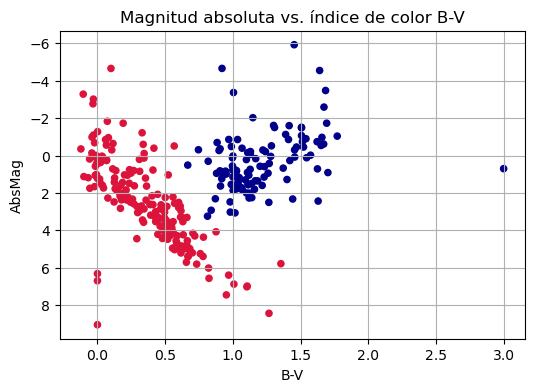

In [358]:
star_sample.plot(x='B-V', y='AbsMag', kind='scatter', figsize=(6,4),
        title='Magnitud absoluta vs. índice de color B-V', color=cmap,
        grid=True, legend=False).invert_yaxis()

## Referencias
La idea de este código ha sido tomada de diversas fuentes, entre ellas:
* [Using Machine Learning in an HR Diagram](https://cocalc.com/share/download/08b6e03583cbdef3cdb9813a54ec68ff773c747f/SDSS/hr03.sagews)
* Introduction to HRD: [The Hertzsprung-Russell Diagram](http://www.atnf.csiro.au/outreach/education/senior/astrophysics/stellarevolution_hrintro.html)
* Sloan Digital Sky Survey DR14 Projects: [The Hertzsprung-Russell Diagram](http://skyserver.sdss.org/dr14/en/proj/advanced/hr/hrhome.aspx)
* scikit-learn documentation: [Clustering](http://scikit-learn.org/stable/modules/clustering.html)
* Hubble Space Telescope: [Hertzsprung-Russell diagram animation](http://www.spacetelescope.org/videos/heic1017b/)